In [59]:
import pickle
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import normalize

#To find the number of SCC in a picture. Refactored from my own CS188 code
def dfs(graph, start, visited=None):
        if visited is None:
            visited = set()
        visited.add(start)
        for next in graph[start] - visited:
            dfs(graph, next, visited)
        return visited
        
def run_dfs(test_img_raw, num_samples, threshold = 127, x_max = 28, y_max = 28):
    dfs_feature = []
    test_img_zero_one = 1*(test_img_raw>threshold)
    for i in range(num_samples):
        if num_samples > 50000 and i % 5000 == 0: 
            print("dfs at step {0}".format(i))
        graph = {}
        for x in range(x_max):
            for y in range(y_max):
                graph[(x,y)] = set()
                if test_img_zero_one[i][x][y] == 1: continue
                if x+1 < x_max and test_img_zero_one[i, x+1, y] == 0:
                    graph[(x,y)].add((x+1, y))
                if x-1 >= 0 and test_img_zero_one[i, x-1, y] == 0:
                    graph[(x,y)].add((x-1, y))
                if y+1 < y_max and test_img_zero_one[i, x, y+1] == 0:
                    graph[(x,y)].add((x, y+1))
                if y-1 >= 0 and test_img_zero_one[i, x, y-1] == 0:
                    graph[(x,y)].add((x, y-1))
        DFS_visited = set()
        SCCs = set()
        
        for x in range(x_max):
            for y in range(y_max):
                if (x,y) in DFS_visited: continue
                if test_img_zero_one[i][x][y] == 1: continue
                SSC_i = dfs(graph, (x,y))
                SCCs.add(frozenset(SSC_i))
                DFS_visited = DFS_visited.union(SSC_i)

        num_of_SCCs = len(SCCs)
        dfs_feature.append(num_of_SCCs)
    return dfs_feature

train_mat = loadmat("dataset/train.mat")
train_img_raw = train_mat["train_images"].T
train_lab = train_mat["train_labels"].ravel()
train_img = np.array([train_img_raw[i].T.flatten() for i in range(60000)])

test_mat = loadmat("dataset/test.mat")
test_img_raw = test_mat["test_images"]
test_img = np.array([test_img_raw[i].reshape(28,28).flatten() for i in range(10000)])

# Run DFS
print("starting DFS for training data!")
dfs_feature = run_dfs(train_img_raw, 60000, 130)
dfs_features = np.zeros((60000, 4))
for i in range(60000):
    if dfs_feature[i] > 3:
        dfs_features[i][3] = 255
    else:
        dfs_features[i][dfs_feature[i]] = 255
train_img = np.array([np.concatenate([train_img[i], dfs_features[i]]) for i in range(60000)])
print("DFS done for training data!\n")

print("starting DFS for testing data!")
dfs_feature1 = run_dfs(test_img_raw.reshape(10000, 28, 28), 10000, 130)
dfs_features1 = np.zeros((10000, 4))
for i in range(10000):
    if dfs_feature1[i] > 3:
        dfs_features1[i][3] = 255
    else:
        dfs_features1[i][dfs_feature1[i]] = 255
test_img = np.array([np.concatenate([test_img[i], dfs_features1[i]]) for i in range(10000)])
print("DFS done for testing data!\n")

# standardize
train_img = normalize(train_img.astype(np.float64))
test_img = normalize(test_img.astype(np.float64))
train_mean, train_std = train_img.mean(), train_img.std()
train_img = (train_img - train_mean) / train_std
test_img = (test_img - train_mean) / train_std

# save standardized data and labels to disk
train_img.dump('train_img.np')
test_img.dump('test_img.np')
train_lab.dump('train_lab.pkl')

starting DFS for training data!
dfs at step 0
dfs at step 5000
dfs at step 10000
dfs at step 15000
dfs at step 20000
dfs at step 25000
dfs at step 30000
dfs at step 35000
dfs at step 40000
dfs at step 45000
dfs at step 50000
dfs at step 55000
DFS done for training data!

starting DFS for testing data!
DFS done for testing data!



In [67]:
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import numpy as np

def print_img(H):
    fig = plt.figure(figsize=(6, 3.2))

    ax = fig.add_subplot(111)
    ax.set_title('colorMap')
    plt.imshow(H)
    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    plt.show()

In [96]:
import numpy as np
from scipy.special import expit
from random import randint
    
#benchmark.m, converted
def benchmark(pred_labels, true_labels):
    errors = pred_labels != true_labels
    err_rate = sum(errors) / float(len(true_labels))
    return err_rate

# Activation Functions
def sigmoid_function(signal, derivative=False):
    signal = np.clip(signal, -500, 500)
    signal = expit(signal)
    if derivative:
        return np.multiply(signal, 1 - signal)
    else:
        return signal

def tanh_function(signal, derivative=False):
    signal = np.tanh( signal )
    if derivative:
        return 1-np.power(signal,2)
    else:
        return signal

# Cost Functions
def sum_squared_error(outputs, targets, derivative=False):
    if derivative:
        return -(outputs - targets)
    else:
        return 0.5 * np.sum(np.power(outputs - targets,2))
    
def cross_entropy_cost(outputs, targets, derivative=False, epsilon=1e-11):
    outputs = np.clip(outputs, epsilon, 1 - epsilon)
    divisor = np.maximum(outputs * (1 - outputs), epsilon)
    if derivative:
        return -(outputs - targets) / divisor / 10**10
    else:
        return -np.sum(targets * np.log( outputs ) + (1 - targets) * np.log(1 - outputs))
    
class NeuralNet(object):
    def __init__(self, X, y, costFN = sum_squared_error, outputLayerSize = 10, \
                 hiddenLayerSize = 200, learning_rate = 1, lamb = 0.0001):
        numberOfSamples = len(y)
        self.X = X[numberOfSamples//6:]
        self.y = y[numberOfSamples//6:]
        self.X_valid = X[:numberOfSamples//6]
        self.y_valid = y[:numberOfSamples//6]
        
        self.costFN = costFN
        self.inputLayerSize = len(X[0])
        self.outputLayerSize = outputLayerSize
        self.hiddenLayerSize = hiddenLayerSize
        self.learning_rate = learning_rate
        self.lamb = lamb
        
        self.V = np.random.randn(self.inputLayerSize, self.hiddenLayerSize)
        self.W = np.random.randn(self.hiddenLayerSize, self.outputLayerSize)
    
    def forward(self, X):
        self.z2 = np.dot(X, self.V)
        self.a2 = tanh_function(self.z2)
        self.z3 = np.dot(self.a2, self.W)
        yHat = sigmoid_function(self.z3)
        return yHat
    
    def costFunction(self):
        yHat = self.forward(self.X)
        return self.costFN(yHat, self.y, False)
    
    def costFunctionPrime(self, Xi, yi):
        yHati = self.forward(Xi)
        
        delta3 = np.multiply(-self.costFN(yHati, yi, True), sigmoid_function(yHati, True))
        dJdW = np.dot(self.a2.T, delta3) / Xi.shape[0] + self.lamb * self.W
        
        delta2 = np.dot(delta3, self.W.T) * tanh_function(self.z2, True)
        dJdV = np.dot(Xi.T, delta2) / Xi.shape[0] + self.lamb * self.V
        
        return dJdV, dJdW
    
    def validation_error(self):
        yHat = self.forward(self.X_valid)
        yPredi = np.argmax(yHat, axis = 1)
        yGiven = np.argmax(self.y_valid, axis = 1)
        return benchmark(yPredi, yGiven)
    
    def training_error(self):
        yHat = self.forward(self.X)
        yPredi = np.argmax(yHat, axis = 1)
        yGiven = np.argmax(self.y, axis = 1)
        return benchmark(yPredi, yGiven)
    
    def stochastic_GD(self, Xi, yi, current_learning_rate):
        dJdV, dJdW = self.costFunctionPrime(Xi, yi)
        self.V = self.V - current_learning_rate*dJdV
        self.W = self.W - current_learning_rate*dJdW
        
    def train(self):
        self.valid_err = []
        self.J = []
        for i in range(1,50000):
            if i % 1000 == 0:
                self.valid_err.append(self.validation_error())
                self.J.append(self.costFunction())
            index = randint(0, len(self.y)-1)
            self.stochastic_GD(np.array([self.X[index]]),\
                               np.array([self.y[index]]), 10000*self.learning_rate/(i+50000))
        self.yHat = self.forward(self.X)
        return np.argmax(self.yHat, axis = 1)
    
    def predict(self, X):
        return np.argmax(self.forward(X), axis = 1)

In [3]:
import pickle
import numpy as np
from scipy.sparse import coo_matrix
from sklearn.utils import shuffle
import time

with open('test_img.np', 'rb') as f:
    test_img = pickle.load(f)
with open('train_img.np', 'rb') as f:
    train_img = pickle.load(f)
with open('train_lab.pkl', 'rb') as f:
    train_lab = pickle.load(f)
    
X_sparse = coo_matrix(train_img)
train_img, X_sparse, train_lab = shuffle(train_img, X_sparse, train_lab, random_state=0)

y = np.zeros((len(train_lab), 10))
for i in range(len(train_lab)):
    y[i][train_lab[i]] = 1
X = train_img

110690.937455
4397.09872838


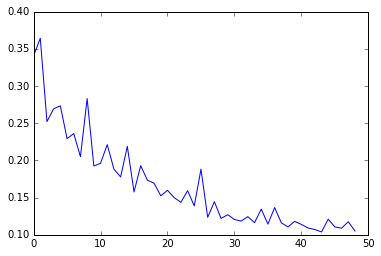

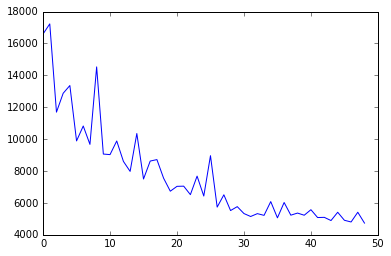

Training finished in 545.6282796110754 seconds
Training accuracy: <bound method NeuralNet.training_error of <__main__.NeuralNet object at 0x000001F480F63860>>
Validation accuracy: <bound method NeuralNet.validation_error of <__main__.NeuralNet object at 0x000001F480F63860>>
3061052.29908
424465.520162


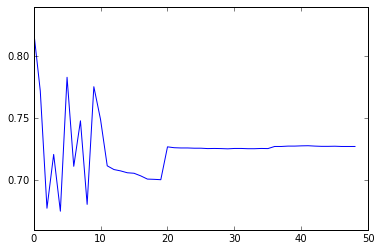

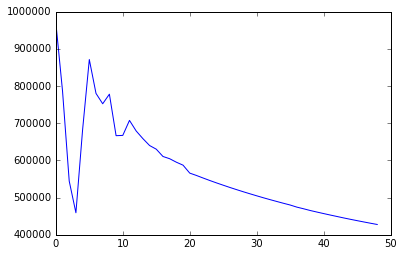

Training finished in 436.79830476535426 seconds
Training accuracy: <bound method NeuralNet.training_error of <__main__.NeuralNet object at 0x000001F480E56B00>>
Validation accuracy: <bound method NeuralNet.validation_error of <__main__.NeuralNet object at 0x000001F480E56B00>>


In [97]:
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt

startTime = time.clock()
NN = NeuralNet(X, y)
print(NN.costFunction())
NN.train()
print(NN.costFunction())
plt.plot(NN.valid_err)
plt.show()
plt.clf()
plt.plot(NN.J)
plt.show()
plt.clf()
endTime = time.clock()
print("Training finished in {} seconds".format(endTime-startTime))

startTime = time.clock()
NN2 = NeuralNet(X, y, cross_entropy_cost)
print(NN2.costFunction())
NN2.train()
print(NN2.costFunction())
plt.plot(NN2.valid_err)
plt.show()
plt.clf()
plt.plot(NN2.J)
plt.show()
plt.clf()
endTime = time.clock()
print("Training finished in {} seconds".format(endTime-startTime))

In [99]:
print("Training accuracy: {}". format(1-NN.training_error()))
print("Validation accuracy: {}". format(1-NN.validation_error()))
print("Training accuracy: {}". format(1-NN2.training_error()))
print("Validation accuracy: {}". format(1-NN2.validation_error()))

Training accuracy: 0.90622
Validation accuracy: 0.8946000000000001
Training accuracy: 0.26376
Validation accuracy: 0.273


In [89]:
import csv
from collections import Counter
predictions = NN.predict(test_img)
print(Counter(predictions))
with open('digit-results-MSE.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    spamwriter.writerow(['Id'] + ['Category'])
    for i in range(len(predictions)):
        spamwriter.writerow([i+1, predictions[i]])

Counter({3: 1173, 1: 1169, 7: 1044, 0: 1019, 9: 1010, 6: 1001, 2: 994, 4: 958, 8: 896, 5: 736})


In [85]:
import csv
from collections import Counter
predictions = NN2.predict(test_img)
print(Counter(predictions))
with open('digit-results-CEC.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    spamwriter.writerow(['Id'] + ['Category'])
    for i in range(len(predictions)):
        spamwriter.writerow([i+1, predictions[i]])

Counter({5: 1510, 2: 1460, 9: 1278, 8: 1227, 6: 999, 1: 898, 4: 724, 3: 687, 7: 647, 0: 570})


In [92]:
import numpy as np
from scipy.special import expit
from random import randint

# Activation Functions
def sigmoid_function(signal, derivative=False):
    signal = np.clip(signal, -500, 500)
    signal = expit(signal)
    if derivative:
        return np.multiply(signal, 1 - signal)
    else:
        return signal

def tanh_function(signal, derivative=False):
    signal = np.tanh( signal )
    if derivative:
        return 1-np.power(signal,2)
    else:
        return signal

# Cost Functions
def sum_squared_error(outputs, targets, derivative=False):
    if derivative:
        return -(outputs - targets)
    else:
        return 0.5 * np.sum(np.power(outputs - targets,2))

class NeuralNetMax(object):
    def __init__(self, X, y, costFN = sum_squared_error, outputLayerSize = 10, \
                 hiddenLayerSize = 200, learning_rate = 1, lamb = 0.0001):
        self.X = X
        self.y = y
        
        self.costFN = costFN
        self.inputLayerSize = len(X[0])
        self.outputLayerSize = outputLayerSize
        self.hiddenLayerSize = hiddenLayerSize
        self.learning_rate = learning_rate
        self.lamb = lamb
        
        self.V = np.random.randn(self.inputLayerSize, self.hiddenLayerSize)
        self.W = np.random.randn(self.hiddenLayerSize, self.outputLayerSize)
    
    def forward(self, X):
        self.z2 = np.dot(X, self.V)
        self.a2 = tanh_function(self.z2)
        self.z3 = np.dot(self.a2, self.W)
        yHat = sigmoid_function(self.z3)
        return yHat
    
    def costFunction(self):
        yHat = self.forward(self.X)
        return self.costFN(yHat, self.y, False)
    
    def costFunctionPrime(self, Xi, yi):
        yHati = self.forward(Xi)
        
        delta3 = np.multiply(-self.costFN(yHati, yi, True), sigmoid_function(yHati, True))
        dJdW = np.dot(self.a2.T, delta3) / Xi.shape[0] + self.lamb * self.W
        
        delta2 = np.dot(delta3, self.W.T) * tanh_function(self.z2, True)
        dJdV = np.dot(Xi.T, delta2) / Xi.shape[0] + self.lamb * self.V
        
        return dJdV, dJdW
    
    def stochastic_GD(self, Xi, yi, current_learning_rate):
        dJdV, dJdW = self.costFunctionPrime(Xi, yi)
        self.V = self.V - current_learning_rate*dJdV
        self.W = self.W - current_learning_rate*dJdW
        
    def train(self):
        self.J = []
        for i in range(1,200000):
            if i % 1000 == 0:
                self.J.append(self.costFunction())
            index = randint(0, len(self.y)-1)
            self.stochastic_GD(np.array([self.X[index]]),\
                               np.array([self.y[index]]), 10000*self.learning_rate/(i+20000))
        self.yHat = self.forward(self.X)
        self.learning_rate = 10000*self.learning_rate/(200000+20000)
        return np.argmax(self.yHat, axis = 1)
    
    def predict(self, X):
        return np.argmax(self.forward(X), axis = 1)

In [94]:
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import pickle

startTime = time.clock()
NNM = NeuralNetMax(X, y)
print(NNM.costFunction())
NNM.train()
print(NNM.costFunction())
endTime = time.clock()
print("Training finished in {} seconds".format(endTime-startTime))
NNM.dump('NNM.np')

145885.048088


KeyboardInterrupt: 

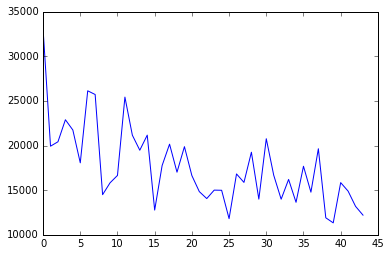

Counter({1: 1327, 8: 1101, 3: 1059, 5: 1007, 4: 982, 6: 958, 7: 940, 0: 935, 2: 925, 9: 766})


In [95]:
import csv
from collections import Counter

plt.plot(NNM.J)
plt.show()
plt.clf()

predictions = NNM.predict(test_img)
print(Counter(predictions))
with open('digit-results-MAX.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    spamwriter.writerow(['Id'] + ['Category'])
    for i in range(len(predictions)):
        spamwriter.writerow([i+1, predictions[i]])